In [36]:
import os, glob, math, argparse
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

# ------ Dataset ------
def WindowDataset(metrics, prices, seq_len=168):
    seq_len = seq_len
    X, y = [], []
    
    returns = np.diff(prices, axis=0)
    y_class = (returns > 0).astype(np.int8)
    
    for t in range(len(metrics) - seq_len):
        X.append(metrics[t:t+seq_len])
        y.append(y_class[t+seq_len-1])
    
    X = np.array(X) # (N, T, F)
    y = np.array(y) # (N, 1)
    return X, y    

def scale_window(win, min_q=1, max_q=99, clip=10.0, coef=1e3):
    """
    win : (T=168, F=74)  raw values
    returns (T, F)  scaled exactly like env.Scaler
    """
    scaler = RobustScaler(quantile_range=(min_q, max_q))
    scaler.fit(win)  # fit on this *window* only
    feats = scaler.transform(win)
    feats = np.clip(feats, -clip, clip)

    return feats.astype(np.float32)      

def split_hourly_daily(window: np.ndarray, col_names: np.ndarray):
    """
    Given a window of shape (seq_len, num_features) and column names,
    - drops the first two columns (assumed to be 'day of week' and 'hour'),
    - separates hourly and daily features,
    - for daily features, returns one row per unique (day_of_week, hour==0) in the window.
    Returns: hourly_data, daily_data
    """
    # Use first two columns for logic, but drop them from features
    day_of_week = window[:, :, 0]
    hour = window[:, :, 1]
    features = window[:, :, 2:]
    col_names = col_names[2:]

    # Find indices for hourly and daily features
    hourly_idx = np.array([i for i, name in enumerate(col_names) if "_1h_" in name])
    daily_idx = np.array([i for i, name in enumerate(col_names) if "_1d_" in name])
     
    # Extract hourly and daily data
    hourly_data = features[:, :, hourly_idx]
    daily_data_full = features[:, :, daily_idx]
    
    # For daily data, select rows where hour == 0 (start of each day)
    N, T, D = daily_data_full.shape
    days = T//24

    daily_data_reshaped = daily_data_full.reshape(N, days, 24, D)
    daily_data = daily_data_reshaped[:, :, 0, :]
    
    return hourly_data, daily_data, col_names[hourly_idx], col_names[daily_idx]

In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} (device)")

# load and split data
metrics_path = os.path.join("data/dataset", "metrics_outfile.npy")
price_path = os.path.join("data/dataset", "price_outfile.npy")
names_path = os.path.join("data/dataset", "feat_names.npy")
X = np.load(metrics_path).astype(np.float32)
y = np.load(price_path).astype(np.float32)
feat_names = np.load(names_path).astype(str)

Using cuda (device)


In [38]:
hourly_idx = np.array([i for i, name in enumerate(feat_names) if "_1h_" in name])
daily_idx = np.array([i for i, name in enumerate(feat_names) if "_1d_" in name])

In [39]:
daily_idx+2

array([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73,
       74, 75])

In [3]:
returns = np.diff(y, axis=0)
y_class = (returns > 0).astype(np.int8)

print(y[3:10].flatten())
print(y_class[3:10].flatten())

[189.99 190.49 191.31 191.22 191.06 191.72 191.52]
[1 1 0 0 1 0 1]


In [ ]:

X_scaled = np.empty_like(X)
for i in tqdm(range(X.shape[0]), desc="Scaling windows"):
    X_scaled[i] = scale_window(X[i])
X_hourly, X_daily, hourly_names, daily_names = split_hourly_daily(X_scaled, feat_names)

Scaling windows: 100%|██████████| 44257/44257 [04:34<00:00, 160.95it/s]


In [5]:
X_hourly, X_daily, hourly_names, daily_names = split_hourly_daily(X_scaled, feat_names)

In [6]:
print(X_hourly.shape, y.shape)
# print(X_hourly.mean(axis=(0, 1)), X_hourly.std(axis=(0, 1)))

print(X_daily.shape, y.shape)
# print(X_daily.mean(axis=(0, 1)), X_daily.std(axis=(0, 1)))

(44257, 168, 36) (44257, 1)
(44257, 7, 36) (44257, 1)


In [7]:
print("Label distribution:", np.unique(y, return_counts=True))

Label distribution: (array([0, 1], dtype=int8), array([21839, 22418], dtype=int64))


[0.35153565 0.35313535 0.34828687 0.3515493  0.33925438 0.33359864
 0.34563836 0.34358522 0.3460969  0.347385   0.32838887 0.3470553
 0.35033515 0.34359196 0.34046918 0.34859774 0.3298652  0.3491058
 0.34693402 0.35336605 0.34568352 0.34686524 0.33941156 0.33617824
 0.34369314 0.34093    0.34387612 0.34334064 0.32754698 0.346809
 0.35021862 0.3416755  0.34052005 0.3500925  0.3320723  0.3449428 ]


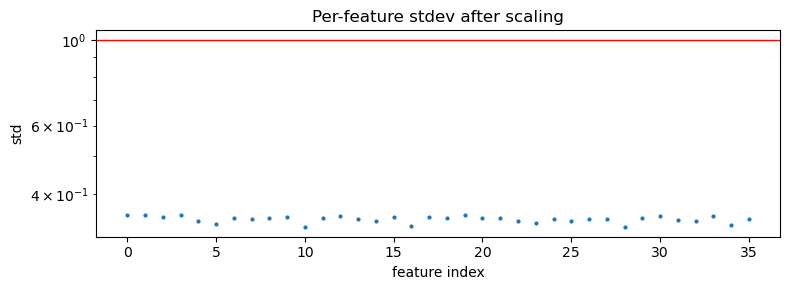

In [8]:
sigmas = X_daily.std(axis=(0, 1))        # shape (F,)
print(sigmas)

plt.figure(figsize=(8,3))
plt.semilogy(sigmas, '.', markersize=4)
plt.axhline(1.0, color='r', lw=1)
plt.title("Per-feature stdev after scaling")
plt.xlabel("feature index"); 
plt.ylabel("std")
plt.tight_layout()

In [9]:
# Save as CNN pretraining dataset as .npy files
save_path = "./data/cnn_pretrain"
np.save(os.path.join(save_path, "hourly_outfile.npy"), X_hourly)
np.save(os.path.join(save_path, "daily_outfile.npy"), X_daily)
np.save(os.path.join(save_path, "targets_outfile.npy"), y)